In [22]:
import sys
sys.path.append('../')
import torch
from tools.utils import manual_seed
import PIL
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt
from tools.img import rgb2yuv, yuv2rgb, rgb_to_yuv, yuv_to_rgb
from torchvision.transforms.transforms import ToTensor
from tools.dataset import get_dataloader, get_dataset_class_and_scale, get_dataset_normalization, get_de_normalization
from omegaconf import OmegaConf
from tools.img import tensor2ndarray, ndarray2tensor
from torchmetrics import StructuralSimilarityIndexMeasure
from tools.dataset import get_dataloader
from tools.inject_backdoor import patch_trigger

manual_seed(42)
loss = StructuralSimilarityIndexMeasure

In [23]:
target_folder = '../' + 'results/gtsrb/inba/20241007012536_wind24'
path = f'{target_folder}/config.yaml'
config = OmegaConf.load(path)
manual_seed(config.seed)

device = f'cuda:{config.device}'
num_class, scale = get_dataset_class_and_scale(config.dataset_name)
if config.model == "resnet18":
    from models.preact_resnet import PreActResNet18
    net = PreActResNet18(num_classes=num_class).to(f'cuda:{config.device}')
elif config.model == "rnp":
    from models.resnet_cifar import resnet18
    net = resnet18(num_classes=num_class).to(f'cuda:{config.device}')
elif config.model == "repvgg":
    from repvgg_pytorch.repvgg import RepVGG
    net = RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_class, width_multiplier=[1.5, 1.5, 1.5, 2.75]).to(device=f'cuda:{config.device}')
else:
    raise NotImplementedError(config.model)
ld = torch.load(f'{target_folder}/results.pth', map_location=device)
net.load_state_dict(ld['model'])
net.to(device)

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

Load a example image and plot RGB channels.

Convert the RGB image to YUV channels, and plot them.

Use INBA to add pertubation to the imaginary part of U channel after FFT.

4
0
tensor([[0.9882, 0.9137, 0.7412],
        [0.8078, 0.7451, 0.6902],
        [0.6196, 0.7176, 0.7686]], device='cuda:0')
tensor([[0.9882, 0.9137, 0.7412],
        [0.8078, 0.7451, 0.6902],
        [0.6196, 0.7176, 0.7686]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(1.4087e-05, device='cuda:0', grad_fn=<MeanBackward0>)


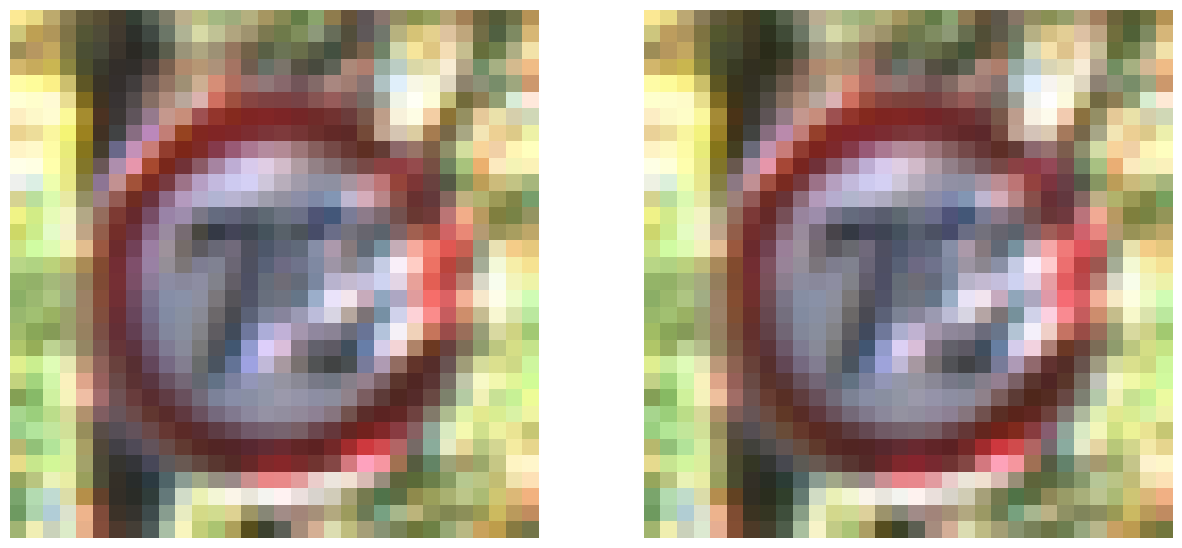

ssim: 0.9980179667472839


/home/chengyiqiu/miniconda3/envs/Diffusion-Backdoor-Embed/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [24]:
_, dl = get_dataloader(config.dataset_name, config.batch, config.pin_memory, config.num_workers)
x_c = None
for batch, label in dl:
    for i in range(batch.shape[0]):
        if label[i] == 4:
            x_c = batch[i]
            break
    if x_c != None:
        break


x_p = patch_trigger(x_c, config)
x_p = get_de_normalization(config.dataset_name)(x_p).squeeze()
x_p = torch.clip(x_p, 0, 1)
x_p = get_dataset_normalization(config.dataset_name)(x_p)
# when training, we do not perform normalization to poison images, which is the same as BackdoorBench.

x_c = x_c.to(device)
x_p = x_p.to(device)

if config.model == 'repvgg':
    net.deploy = True
net.eval()
with torch.no_grad():
    out_c = net(x_c.unsqueeze(0))
    out_p = net(x_p.unsqueeze(0))
    _, y_c = torch.max(out_c, 1)
    _, y_p = torch.max(out_p, 1)

print(y_c.item())
print(y_p.item())
print(x_c[0, 0:3, 0:3])
print(x_p[0, 0:3, 0:3])

print((x_c - x_p).mean())

x_c = get_de_normalization(config.dataset_name)(x_c).squeeze()
x_p = get_de_normalization(config.dataset_name)(x_p).squeeze()


_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(tensor2ndarray(x_c))
ax[0].axis('off')
ax[1].imshow(tensor2ndarray(x_p))
ax[1].axis('off')
plt.show()
ssim_metric = loss(data_range=1.0).to(device)(x_c.unsqueeze(0), x_p.unsqueeze(0))
print(f'ssim: {ssim_metric}')